In [274]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import chi2_contingency

Задание 2

- Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. 
- Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. 
- При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

- Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [275]:
test_data = pd.read_csv('https://stepik.org/media/attachments/lesson/409318/problem2.csv', sep=';')

In [276]:
test_data.isna().sum()  # смотрим пропуски

user_id      0
revenue      0
testgroup    0
dtype: int64

In [277]:
test_data.shape[0] == test_data.user_id.nunique()  # дубликатов нет

True

In [278]:
test_data.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [331]:
control = test_data[test_data.testgroup == 'a']['revenue']
test = test_data[test_data.testgroup == 'b']['revenue']  # разобьем данные на 2 таблицы по группам

In [332]:
arpu = test_data.groupby('testgroup', as_index = False).agg({'revenue' : 'sum', 'user_id' : 'count'})

In [333]:
arpu['arpu'] = arpu.revenue / arpu.user_id

In [334]:
arpu

,testgroup,revenue,user_id,arpu
0,a,5136189,202103,25.413720
1,b,5421603,202667,26.751287


Один из главных смыслов делать скидки и акционные предложения- это повысить конверсию в покупку. Те, кто не купили бы раньше- должны это сделать. Кто итак покупал- купят больше и т.д. Поэтому сравним значения платящих пользователей

In [335]:
test_data['convertion'] = np.where(test_data['revenue'] != 0, True, False)

In [341]:
test_convertion = pd.crosstab(test_data['testgroup'], test_data['convertion'], normalize='index')

In [342]:
test_convertion

convertion,False,True
testgroup,,
a,0.990460,0.009540
b,0.991094,0.008906


- В группе В показатель хуже -  А конверсия 0.0095, Б 0.0089. 

- В данном случае я бы сказала, что не так важно на сколько, достаточно, что динамика отрицательная. Ожидается, что он должен сильно вырасти. Но всё же проверим стат.значимость по критерию хи квадрат:

In [348]:
chi_test = pd.crosstab(test_data['testgroup'], test_data['convertion'])
round(chi2_contingency(chi_test)[1], 5)

0.03648

 p-value < 0,05  различие стат.значимо.

Посмотрим как изменились другие показатели. 

In [287]:
average_check_control = 5136189/1928

In [288]:
average_check_test = 5421603/1805

In [289]:
round(average_check_control)  # средний чек в контрольной группе

2664

In [290]:
round(average_check_test)  # средний чек в тестовой группе

3004

Средний чек среди платящих пользователей увеличился на 11%. Т.е. вероятно, те, кто хотел купить товар - с помощью акции взяли больше, чем обычно. 
В идеале акция должна увеличивать как конверсию в покупку, так и средний чек - те, кто не хотел купить- должны захотеть, а кто хотел- купить больше. 

На этом этапе я бы сказала, что акция неудачная и нужно тестировать новые варианты акционных предложений. 

Посмотрим на данные в целом . 
- Очень низкая конверсия в покупку
- В контрольной группе есть выбросы, но в зависимости от специфики товара это скорее всего нормально. Всегда будут те, кто покупает очень много и таких будет пропорционально очень мало. В нашем случае меньше 0.06% 

In [291]:
control.describe()

count    202103.000000
mean         25.413720
std         920.768137
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       37433.000000
Name: revenue, dtype: float64

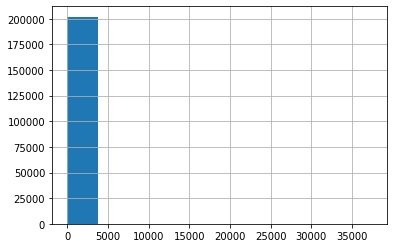

In [292]:
control.hist()

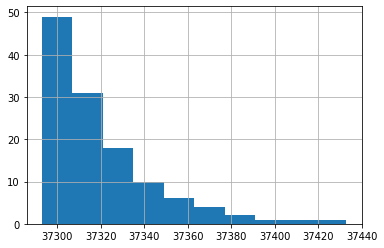

In [293]:
control[control > 5000].hist()

In [320]:
control[control > 5000].describe()

count      123.000000
mean     37319.121951
std         25.442183
min      37293.000000
25%      37301.000000
50%      37311.000000
75%      37329.000000
max      37433.000000
Name: revenue, dtype: float64

In [322]:
control[control < 5000].describe()

count    201980.000000
mean          2.702926
std          28.985815
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         400.000000
Name: revenue, dtype: float64

Смотрим как покупают те, кто платит больше среднего чека. 
- 123 человека купили примерно в 13 раз больше, чем в среднем другие клиенты. 

В тестовой группе таких выбросов даже близко нет. Там максимальное значение 4000, против 37433 в контрольной. 

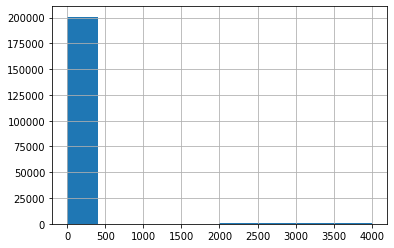

In [295]:
test.hist()  # как распределились оплаты в тестовой группе

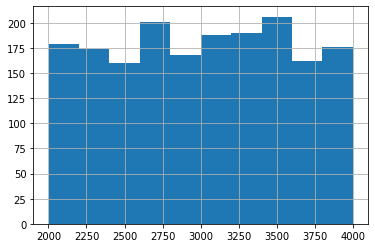

In [317]:
test[test > 2000].hist()  # тестовая группа выбросы

In [297]:
test.describe()

count    202667.000000
mean         26.751287
std         287.324162
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        4000.000000
Name: revenue, dtype: float64

In [325]:
test[test > 2000].describe()

count    1804.000000
mean     3004.214523
std       572.290298
min      2001.000000
25%      2513.000000
50%      3022.500000
75%      3478.250000
max      4000.000000
Name: revenue, dtype: float64

Посчитаем в целом, сколько денег получили от двух групп и какой средний чек среди платящих. 

In [303]:
test_data.groupby('testgroup').agg({'revenue': 'sum'})

,revenue
testgroup,
a,5136189
b,5421603


In [304]:
control[control > 5000].sum()  # считаем выручку в контрольной группе - А- среди "выбросов"

4590252

In [328]:
control[control > 5000].count()

123

In [326]:
test[test > 2000].sum()  # считаем выручку в тестовой группе среди - Б- "выбросов"

5419603

In [330]:
test[test > 2000].count()

1804

Т.е. по этим данным получается, что в тестовой группе очень маленький процент пользователей приносит большую часть выручки. 
Для экономики это плохо, но это может быть точкой роста, если разобраться, почему они всё же покупали. Пропорционально в тестовой группе таких клиентов больше. 

В целом- акционные предожения из тестовой группы показали себя плохо из-за низкой конверсии и не очень высокого роста среднего чека. 